In [24]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from keras.layers import SimpleRNN, Dropout, Dense
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from tqdm.keras import TqdmCallback

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PJME_hourly.csv')
df.head(10)

Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0
5  2002-12-31 06:00:00  26222.0
6  2002-12-31 07:00:00  28702.0
7  2002-12-31 08:00:00  30698.0
8  2002-12-31 09:00:00  31800.0
9  2002-12-31 10:00:00  32359.0

In [4]:
import plotly.graph_objs as go
from plotly.offline import iplot

def plot_dataset(df, title):
    data = []

    value = go.Scatter(
        x=df.index,
        y=df.value,
        mode="lines",
        name="values",
        marker=dict(),
        text=df.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    layout = dict(
        title=title,
        xaxis=dict(title="Date", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)

if 'Datetime' not in df.index.names:
    df = df.set_index(['Datetime'])  # Set 'Datetime' as index if not already

df = df.rename(columns={'PJME_MW': 'value'})

df.index = pd.to_datetime(df.index)
df = df.sort_index()
plot_dataset(df, title='PJM East (PJME) Region: Estimated Energy Consumption in Megawatts (MW)')

In [5]:
df.head()

value
Datetime                    
2002-01-01 01:00:00  30393.0
2002-01-01 02:00:00  29265.0
2002-01-01 03:00:00  28357.0
2002-01-01 04:00:00  27899.0
2002-01-01 05:00:00  28057.0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   value   145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


In [64]:
df.to_csv('PJME_preprocessed.csv')

In [7]:
def create_lagged_features(data, n_lags=5):
    for lag in range(1, n_lags + 1):
        data[f'value_lag{lag}'] = data['value'].shift(lag)
    return data.dropna()

df = create_lagged_features(df)


In [8]:
def apply_ema(data, span=10):
    data['value_ema'] = data['value'].ewm(span=span, adjust=False).mean()
    return data

df = apply_ema(df)

In [9]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['value'] + [f'value_lag{i}' for i in range(1, 6)] + ['value_ema']])


In [10]:
# Define input features (X) and target (y)
X = scaled_data[:, 1:]  # Use lagged and EMA values as features
y = scaled_data[:, 0]   # Original value column as target

# Reshape for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


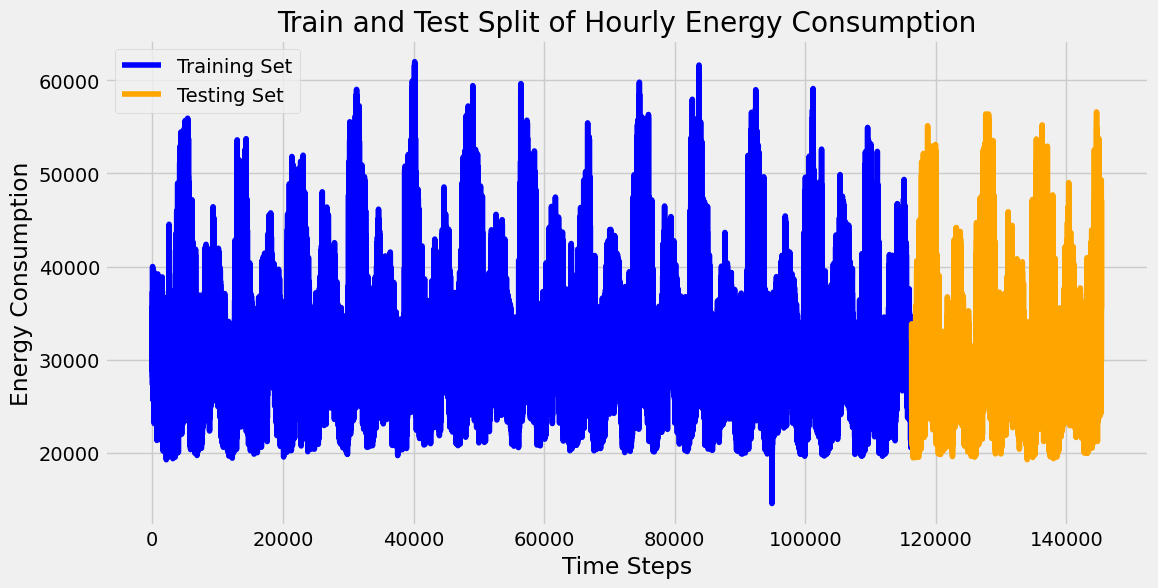

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Inverse transform the scaled train and test data for better interpretation

train_values = scaler.inverse_transform(
    np.concatenate((y_train.reshape(-1, 1), np.zeros((y_train.shape[0], 6))), axis=1) # Changed X.shape[2] - 1 to 6
)[:, 0]

test_values = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 6))), axis=1) # Changed X.shape[2] - 1 to 6
)[:, 0]

# Plot the training and testing data
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_values)), train_values, label='Training Set', color='blue')
plt.plot(range(len(train_values), len(train_values) + len(test_values)), test_values, label='Testing Set', color='orange')
plt.title("Train and Test Split of Hourly Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption")
plt.legend()
plt.show()

In [37]:
# Initializing model building with Simple RNN
def build_model2(X_train):
    model = Sequential([
        SimpleRNN(32, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build and Train Model
model2 = build_model2(X_train)
history = model2.fit(X_train, y_train, epochs= 10, batch_size=32, validation_data=(X_test, y_test), verbose = 0 ,callbacks=[TqdmCallback()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

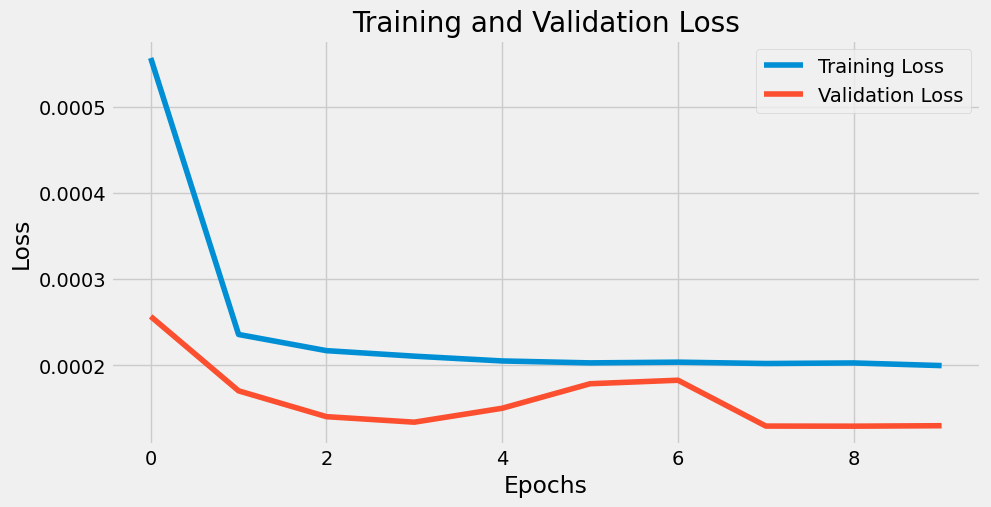

In [39]:

def plot_training_history(history):
    """
    Plots the training and validation loss of the model.

    Parameters:
        history (History): Keras History object containing training metrics.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_history(history)

In [40]:
# Initializing model building with LSTM
def build_model1_simplified(X_train):
    model = Sequential([
        LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build and Train Model
model1 = build_model1(X_train)
history = model1.fit(X_train, y_train, epochs= 10, batch_size=32, validation_data=(X_test, y_test), verbose = 0 ,callbacks=[TqdmCallback()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

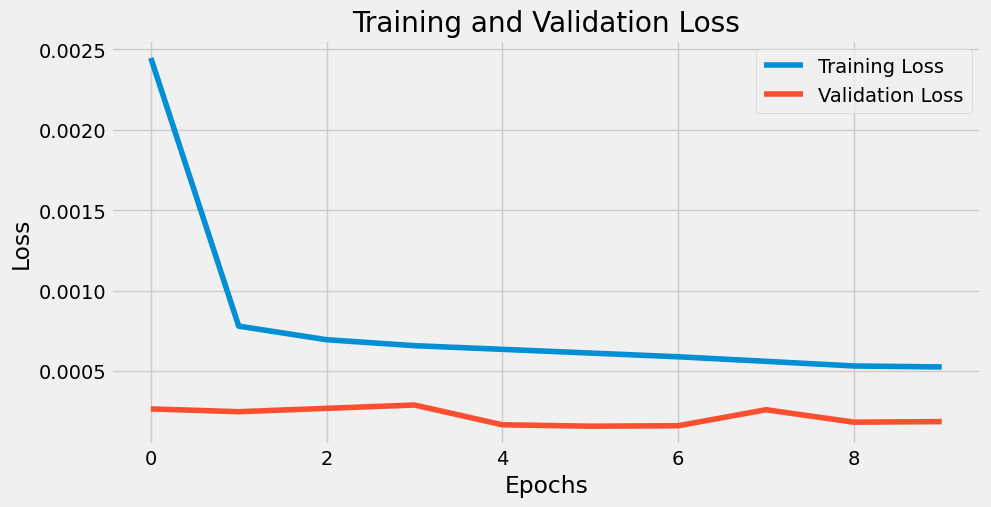

In [41]:
plot_training_history(history)

In [42]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluates the given model on test data using MAE, MSE, RMSE, MAPE, and R² score.

    Parameters:
        model (tf.keras.Model): Trained LSTM model to evaluate.
        X_test (np.ndarray): Test feature set.
        y_test (np.ndarray): True target values for the test set.
        scaler (MinMaxScaler): Scaler used for inverse transforming the predictions and true values.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    y_pred = model.predict(X_test)

    num_features_scaler = scaler.n_features_in_
    y_test_reshaped = np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], num_features_scaler - 1))), axis=1)
    y_pred_reshaped = np.concatenate((y_pred, np.zeros((y_pred.shape[0], num_features_scaler - 1))), axis=1)

    # Inverse transform the predictions and true values for interpretability
    y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, 0]
    y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, 0]

    # Calculating Evaluation Metrics
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    print("Evaluation Metrics for Energy Consumption Forecasting:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")
    print(f"R² Score: {r2:.2f}")

In [43]:
def plot_true_vs_predicted(model, X_test, y_test, scaler):
    """
    Plots the true vs. predicted values for the test set.

    Parameters:
        model (tf.keras.Model): Trained model to use for predictions.
        X_test (np.ndarray): Test feature set.
        y_test (np.ndarray): True target values for the test set.
        scaler (MinMaxScaler): Scaler used for inverse transforming the predictions and true values.
    """
    # Predict and inverse transform predictions and true values
    y_pred = model.predict(X_test)

    # Reshape and scale back
    num_features_scaler = scaler.n_features_in_
    y_test_reshaped = np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], num_features_scaler - 1))), axis=1)
    y_pred_reshaped = np.concatenate((y_pred, np.zeros((y_pred.shape[0], num_features_scaler - 1))), axis=1)

    y_test_inv = scaler.inverse_transform(y_test_reshaped)[:, 0]
    y_pred_inv = scaler.inverse_transform(y_pred_reshaped)[:, 0]

    # Plotting true vs predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inv, label='True Values')
    plt.plot(y_pred_inv, label='Predicted Values', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Energy Consumption')
    plt.title('True vs. Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()



In [44]:
# for RNN
evaluate_model(model2, X_test, y_test, scaler)

909/909 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Evaluation Metrics for Energy Consumption Forecasting:
Mean Absolute Error (MAE): 405.5768474949914
Mean Squared Error (MSE): 292892.23121481156
Root Mean Squared Error (RMSE): 541.1951877232572
Mean Absolute Percentage Error (MAPE): 1.32%
R² Score: 0.99


909/909 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


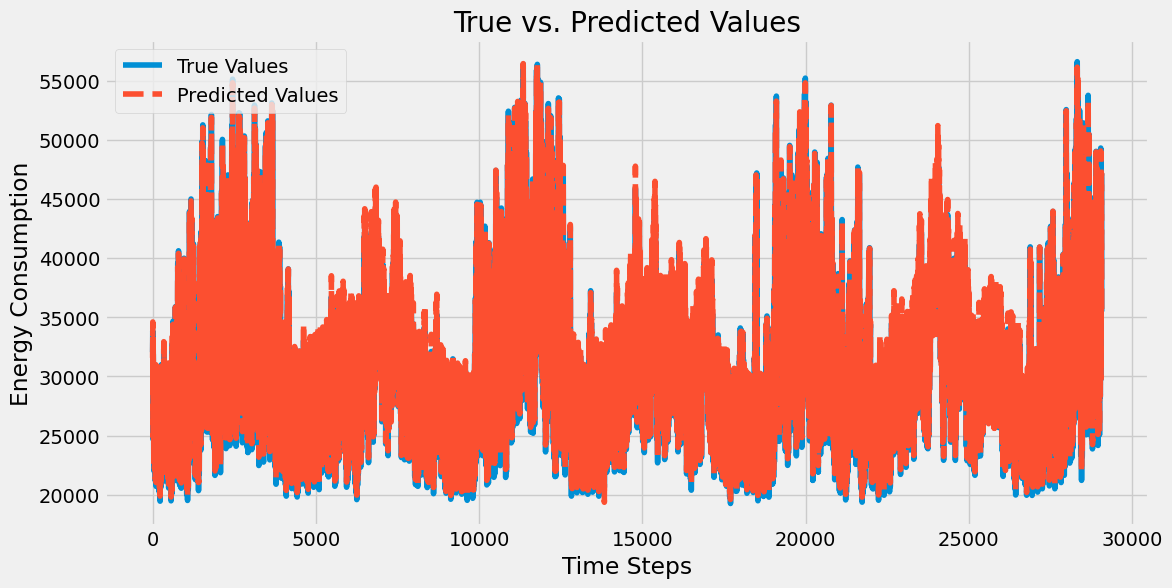

In [45]:
plot_true_vs_predicted(model2, X_test, y_test, scaler)

In [46]:
#for LSTM
evaluate_model(model1, X_test, y_test, scaler)

909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Evaluation Metrics for Energy Consumption Forecasting:
Mean Absolute Error (MAE): 515.5634985085594
Mean Squared Error (MSE): 420366.2098098723
Root Mean Squared Error (RMSE): 648.3565452818938
Mean Absolute Percentage Error (MAPE): 1.74%
R² Score: 0.99


909/909 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


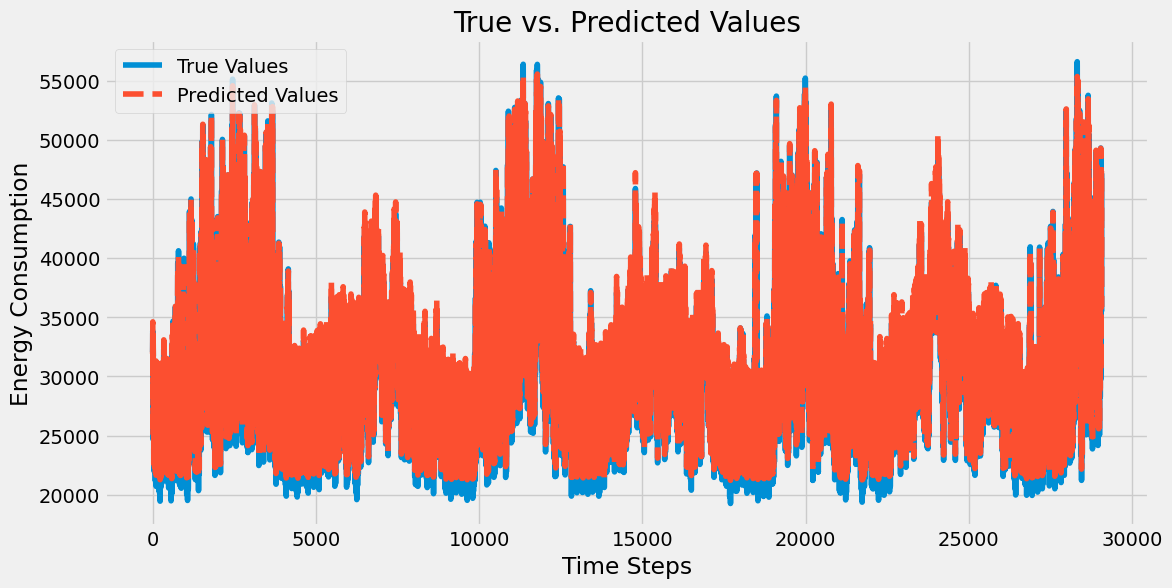

In [47]:
plot_true_vs_predicted(model1, X_test, y_test, scaler)

In [65]:
model1.save('lstmmodel.keras')

In [61]:
def forecast(model, last_input, future_steps= 10):
    predictions = []
    current_input = last_input

    for _ in range(future_steps):
        pred = model.predict(current_input.reshape(1, 1, -1))
        predictions.append(pred[0, 0])

        #Updating current input with the prediction to forecast further
        current_input = np.roll(current_input, -1)
        current_input[-1] = pred

    return np.array(predictions)

last_input = X_test[-1, 0, :]
future_predictions = forecast(model1, last_input)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-61-b3df59d0ff54>:11: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [62]:
import plotly.graph_objects as go
def plot_forecast_interactive(true_values, future_predictions, forecast_steps=24):
    """
    Plots the true values and forecasted future values interactively.

    Parameters:
        true_values (np.ndarray): Array of true values from the test set.
        future_predictions (np.ndarray): Array of forecasted values for the future.
        forecast_steps (int): Number of future time steps forecasted.
    """
    # Generate time steps for the forecasted period
    future_time_steps = np.arange(len(true_values), len(true_values) + forecast_steps)

    fig = go.Figure()

    # Change: Access the true_values array correctly, as it is 1-dimensional
    fig.add_trace(go.Scatter(x=np.arange(len(true_values)), y=true_values, mode='lines', name='True Values', line=dict(color='blue')))


    fig.add_trace(go.Scatter(x=future_time_steps, y=future_predictions, mode='lines', name='Forecasted Values', line=dict(color='red', dash='dash')))
    fig.update_layout(
        title="True vs. Forecasted Energy Consumption",
        xaxis_title="Time Steps",
        yaxis_title="Energy Consumption",
        template="plotly_dark",
        showlegend=True
    )

    fig.show()


plot_forecast_interactive(y_test[-20:], future_predictions)  # Adjust y_test[-24:] if necessary to match the forecast steps